In [183]:
import numpy as np
import matplotlib.pyplot as plt

In [184]:
class RandomAction:
    def __init__(self, n_states=1000, left_reward=-1):
        self.n_states = n_states
        self.left_reward = left_reward
        self.reset()

    def reset(self):
        self.state = self.n_states // 2
        return self.state

    def step(self):
        action = 0
        while action == 0:
            action = np.random.randint(-100, 101)

        self.state += action

        if self.state < 0:
            return self.state, self.left_reward, True
        elif self.state >= self.n_states:
            return self.state, 1, True
        return self.state, 0, False

In [185]:
V = np.zeros(1000)
N = np.zeros(1000)

episodes = 100000
alpha = 2e-5

FIRST_VISIT = False

env = RandomAction()

for episode in range(episodes):
    state = env.reset()

    states = []
    rewards = []

    done = False

    while not done:
        states.append(state)
        state, reward, done = env.step()
        rewards.append(reward)
        
    G = 0
    for i in reversed(range(len(states))):
        if not FIRST_VISIT or states[i] not in states[:i]:
            G = G + rewards[i]
            N[states[i]] += 1
            V[states[i]] += (G - V[states[i]]) / N[states[i]]

In [186]:
class TileCoding:
    def __init__(self, tile_width, n_tiles, n_slices, tile_gap, alpha, do=False):
        self.n_tiles = n_tiles
        self.n_slices = n_slices
        self.tile_gap = tile_gap
        self.tile_width = tile_width
        self.alpha = alpha
        self.tile = []
        for i in range(n_tiles):
            tile_index = []
            for j in range(n_slices):
                tile_index.append(-i * tile_gap + j * tile_width)
            self.tile.append(tile_index)
        
        if do:
            self.do()

    def get_tile_index(self, states):
        tile_index = np.zeros((len(states), self.n_tiles * self.n_slices))
        for k in range(len(states)):
            state = states[k]
            for i in range(self.n_tiles):
                start_val = self.tile[i][0]
                for j in range(self.n_slices):
                    if start_val <= state < start_val + self.tile_width:
                        tile_index[k][i * self.n_slices + j] = 1
                    else:
                        tile_index[k][i * self.n_slices + j] = 0
                    start_val += self.tile_width
        return tile_index

    def get_V(self, x):
        return np.dot(self.w, x)
    
    def get_Vs(self, xs):
        return np.dot(self.w, xs.T)
    
    def get_grad_V(self, x):
        return x
    
    def root_average_square(self, v_hat):
        return np.sqrt(np.mean((v_hat - V) ** 2))

    def do(self):
        self.ras = []
        env = RandomAction()
        episodes = 10000

        self.w = np.zeros(self.n_tiles * self.n_slices)
        self.N = np.zeros(self.n_tiles * self.n_slices)


        for episode in range(episodes):
            state = env.reset()

            states = []
            rewards = []
            done = False

            while not done:
                states.append(state)
                state, reward, done = env.step()
                rewards.append(reward)

            G = []
            g = 0
            for i in reversed(range(len(states))):
                g += rewards[i]
                G.append(g)
            G.reverse()

            new_w = np.copy(self.w)
            states = self.get_tile_index(states)
            for i in range(len(G)):
                new_w += self.alpha * (G[i] - self.get_V(states[i])) * self.get_grad_V(states[i])

            self.w = new_w
            self.ras.append(self.root_average_square(self.get_Vs(self.get_tile_index(range(1000)))))

In [187]:
t_s = []

for i in range(3):
    t = [TileCoding(*j, do=True) for j in [(200, 50, 6, 4, 0.0001/50), (200, 1, 6, 4, 0.0001)]]
    t_s.append(t)

In [190]:
t1_V = [np.dot(t[0].w, t[0].get_tile_index(np.arange(1000)).T) for t in t_s]
t2_V = [np.dot(t[1].w, t[1].get_tile_index(np.arange(1000)).T) for t in t_s]

t1_ras = [t[0].ras for t in t_s]
t2_ras = [t[1].ras for t in t_s]

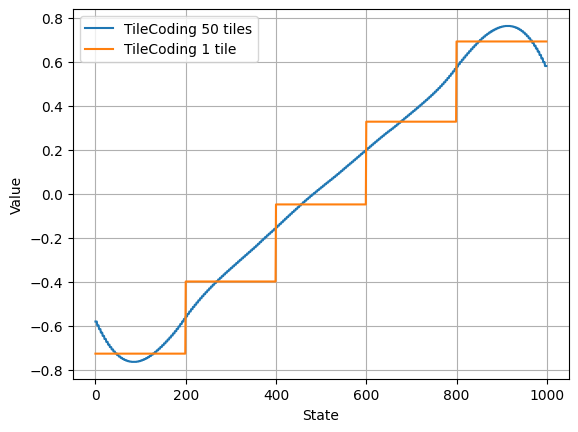

In [191]:
plt.plot(np.mean(t1_V, axis=0), label='TileCoding 50 tiles')
plt.plot(np.mean(t2_V, axis=0), label='TileCoding 1 tile')

plt.legend()
plt.grid()
plt.xlabel('State')
plt.ylabel('Value')
plt.show()

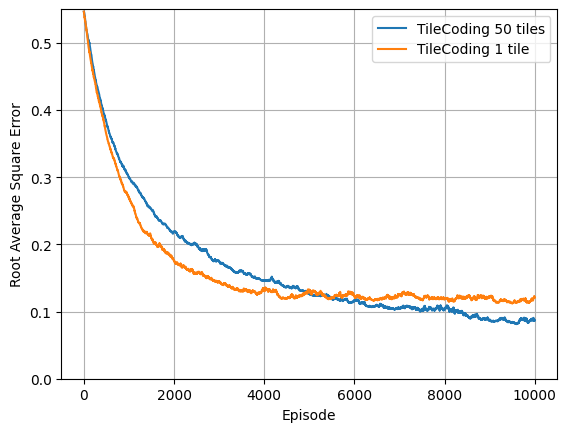

In [192]:
plt.plot(np.mean(t1_ras, axis=0), label='TileCoding 50 tiles')
plt.plot(np.mean(t2_ras, axis=0), label='TileCoding 1 tile')

plt.legend()
plt.grid()
plt.ylim(0, 0.55)
plt.xlabel('Episode')
plt.ylabel('Root Average Square Error')
plt.show()